In [16]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

import mlflow
from mlflow.models import infer_signature
import mlflow.sklearn

import logging

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [4]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [5]:
def load_and_process_data():
    # Read the csv files
    data = pd.read_csv('data/application_record.csv')
    record = pd.read_csv('data/credit_record.csv')

    # find all users' account open month.
    begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
    begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 

    new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record datatrain_raw_data.head()

    record['dep_value'] = None
    record.loc[record['STATUS'].isin(['2', '3', '4', '5']), 'dep_value'] = 'Yes'

    cpunt=record.groupby('ID').count()
    cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
    cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
    cpunt = cpunt[['dep_value']]

    merge_data=pd.merge(new_data,cpunt,how='inner',on='ID')
    return merge_data

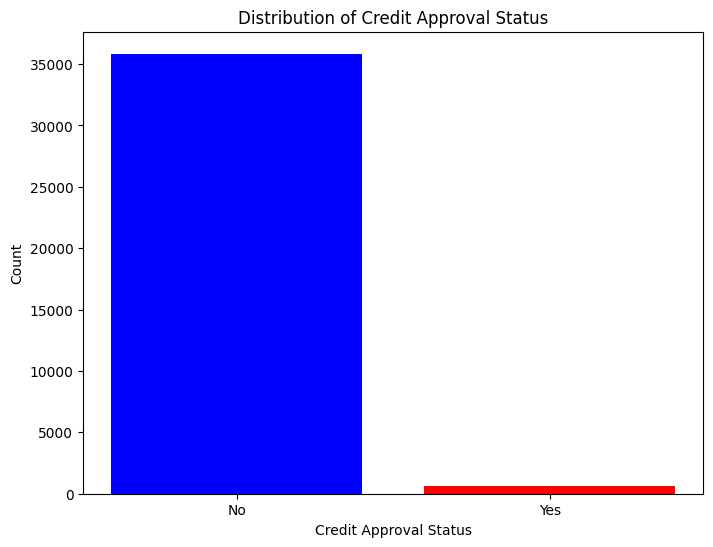

In [15]:
# Counts of each class in the target variable
merge_data = load_and_process_data()
class_counts = merge_data['dep_value'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'])
plt.xlabel('Credit Approval Status')
plt.ylabel('Count')
plt.title('Distribution of Credit Approval Status')
plt.show()

In [6]:
def preprocess_data(merge_data):
    # Check for missing values (NaN) in the DataFrame
    print(merge_data.isna().sum())

    # Drop rows with any NaN values
    merge_data.dropna(inplace=True)

    # Display the first few rows of the cleaned DataFrame
    merge_data.head()

    # Now, we remove OCCUPATION_TYPE. As we said, it have too many missed data
    # In addition, we will get rid of FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE and FLAG_EMAIL. 
    # These parameters do not affect in any way whether a person is creditworthy or not.
    merge_data.drop(['ID','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'], axis=1, inplace=True) 

    # Now, let's convert all non-numeric data to numeric data using LabelEncoder().
    le = LabelEncoder()
    for x in merge_data:
        if merge_data[x].dtypes == 'object':
            merge_data[x] = le.fit_transform(merge_data[x])

    data = merge_data.copy()

    X = data.iloc[:,1:-1] # X value contains all the variables except labels
    y = data.iloc[:,-1] # these are the labels

    # Split the data into training and test sets. (0.70, 0.30) split.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    oversample = SMOTE()
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    X_test, y_test = oversample.fit_resample(X_test, y_test)
    
    return X_train, X_test, y_train, y_test

In [10]:
def get_experiment_id(experiment_name):
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment:
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)

In [17]:
def train_models(X_train, X_test, y_train, y_test):

    mlflow.set_tracking_uri("sqlite:///mlflow.db")
    experiment_id = get_experiment_id("simple_exp")

    models = [
        {"name": "RandomForest",
         "model": RandomForestRegressor(),
         "parameters": {"n_estimators": [10, 50, 100], "max_depth": [None, 5, 10]}},
        {"name": "ElasticNet",
         "model": ElasticNet(),
         "parameters": {"alpha": [0.1, 0.5, 1.0], "l1_ratio": [0.1, 0.5, 1.0]}},
        {"name": "DecisionTree",
         "model": DecisionTreeRegressor(),
         "parameters": {"max_depth": [None, 5, 10]}},
        {"name": "GradientBoosting",
         "model": GradientBoostingRegressor(),
         "parameters": {"n_estimators": [50, 100, 150], "learning_rate": [0.01, 0.1, 1.0]}},
        {"name": "XGBoost",
         "model": XGBRegressor(),
         "parameters": {"n_estimators": [50, 100, 150], "learning_rate": [0.01, 0.1, 1.0]}},
        # Add more models here
    ]

    for model_info in models:
        model_name = model_info["name"]
        model = model_info["model"]
        param_grid = model_info["parameters"]

        for parameters in ParameterGrid(param_grid):
            model.set_params(**parameters)
            with mlflow.start_run(experiment_id=experiment_id):
                model.fit(X_train, y_train)

                predicted_qualities = model.predict(X_test)

                (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)

                print(f"{model_name} model (parameters={parameters}):")
                print("  RMSE: %s" % rmse)
                print("  MAE: %s" % mae)
                print("  R2: %s" % r2)

                mlflow.log_param("model_name", model_name)
                mlflow.log_params(parameters)
                mlflow.log_metric("rmse", rmse)
                mlflow.log_metric("r2", r2)
                mlflow.log_metric("mae", mae)

                predictions = model.predict(X_train)
                signature = infer_signature(X_train, predictions)

                mlflow.sklearn.log_model(model, f"{model_name}_model", signature=signature)

In [18]:
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(40)

    merge_data = load_and_process_data()
    X_train, X_test, y_train, y_test = preprocess_data(merge_data)
    train_models(X_train, X_test, y_train, y_test)

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
begin_month                0
dep_value                  0
dtype: int64
RandomForest model (parameters={'max_depth': None, 'n_estimators': 10}):
  RMSE: 0.3739611750002683
  MAE: 0.2047116208912273
  R2: 0.4406121583696747
RandomForest model (parameters={'max_depth': None, 'n_estimators': 50}):
  RMSE: 0.3653397971299176
  MAE: 0.20297122760414474
  R2: 0.4661073305322826
RandomForest model (parameters={'max_depth': None, 'n_estimators': 100}):
  RMSE: 0.366171865652859
  MA

In [19]:
experiment_id = get_experiment_id("simple_exp")
runs = mlflow.search_runs(experiment_ids=[experiment_id])

# Sort by one of the metrics and get the top run
best_run = runs.sort_values("metrics.rmse").iloc[0]

params = best_run.loc[[name.startswith("params.") for name in best_run.index]]
metrics = best_run.loc[[name.startswith("metrics.") for name in best_run.index]]

params
metrics

metrics.mae     0.169126
metrics.rmse    0.250615
metrics.r2      0.748769
Name: 3, dtype: object

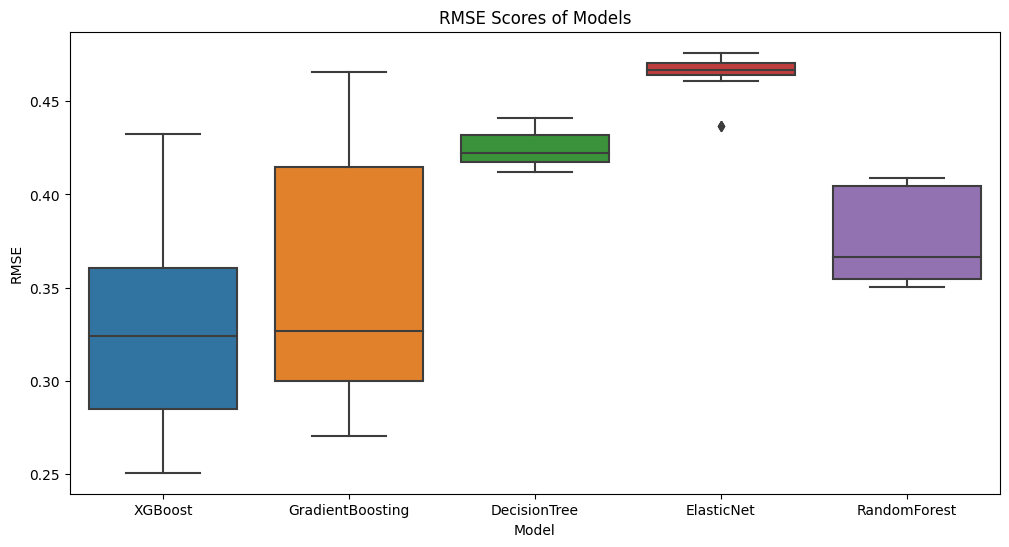

In [20]:
# Create a boxplot for RMSE scores of each model
plt.figure(figsize=(12, 6))
sns.boxplot(data=runs, x='params.model_name', y='metrics.rmse')
plt.title('RMSE Scores of Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()